In [1]:
!unzip  "/content/drive/MyDrive/house_price/word2vec-nlp-tutorial.zip"

Archive:  /content/drive/MyDrive/house_price/word2vec-nlp-tutorial.zip
  inflating: labeledTrainData.tsv.zip  
  inflating: sampleSubmission.csv    
  inflating: testData.tsv.zip        
  inflating: unlabeledTrainData.tsv.zip  


In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
import nltk
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import callbacks, models, layers
import matplotlib.pyplot as plt

# tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
MAX_WORDS = 25_000

In [4]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
!unzip "/content/labeledTrainData.tsv.zip"

Archive:  /content/labeledTrainData.tsv.zip
  inflating: labeledTrainData.tsv    


In [6]:
!unzip "/content/testData.tsv.zip"

Archive:  /content/testData.tsv.zip
  inflating: testData.tsv            


In [7]:
import pandas as pd



tsv_file_path_train = "/content/labeledTrainData.tsv"
tsv_file_path_test = "/content/testData.tsv"


train = pd.read_csv(tsv_file_path_train, sep='\t')
test = pd.read_csv(tsv_file_path_test, sep='\t')


print(train.head())
print(test.head())


       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...


In [8]:
train.shape, test.shape


((25000, 3), (25000, 2))

In [9]:
print(train["sentiment"][0])
train["review"][0]

1


"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [10]:
stop_words = stopwords.words("english")
def clean(review):
    clean_html = BeautifulSoup(review).get_text()
    clean_non_letters = re.sub("[^a-zA-Z]", " ", clean_html)
    cleaned_lowercase = clean_non_letters.lower()
    words = cleaned_lowercase.split()
    cleaned_words = [w for w in words if w not in stop_words]
    return " ".join(cleaned_words)

train["cleaned_review"] = train["review"].apply(clean)
train

<ipython-input-10-9780c70dd433>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_html = BeautifulSoup(review).get_text()


,id,sentiment,review,cleaned_review
0,5814_8,1,With all this stuff going down at the moment w...,stuff going moment mj started listening music ...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war worlds timothy hines entertaining ...
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,film starts manager nicholas bell giving welco...
3,3630_4,0,It must be assumed that those who praised this...,must assumed praised film greatest filmed oper...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious explo...
...,...,...,...,...
24995,3453_3,0,It seems like more consideration has gone into...,seems like consideration gone imdb reviews fil...
24996,5064_1,0,I don't believe they made this film. Completel...,believe made film completely unnecessary first...
24997,10905_3,0,"Guy is a loser. Can't get girls, needs to buil...",guy loser get girls needs build picked stronge...
24998,10194_3,0,This 30 minute documentary Buñuel made in the ...,minute documentary bu uel made early one spain...


In [11]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train.cleaned_review)
total_words = len(tokenizer.word_index) + 1
total_words

74066

In [12]:
sequences = tokenizer.texts_to_sequences(train.cleaned_review)
max_sequence_len = max([len(x) for x in sequences])
padded_sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))
labels = np.array(train.sentiment)
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(20000, 1322) (20000,) (5000, 1322) (5000,)


In [13]:
def to_dataset(data, labels):
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    dataset = dataset.cache().shuffle(X_train.shape[0] + 1).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset
train_ds = to_dataset(X_train, y_train)
val_ds = to_dataset(X_val, y_val)

In [14]:
from tensorflow.keras import models, layers

LSTM_SIZE = 64  # Increase the LSTM size
EMBEDDING_DIM = 64  # Increase the embedding dimension

def bi_lstm_model(total_words, max_sequence_len):
    model = models.Sequential()
    model.add(layers.Embedding(total_words, EMBEDDING_DIM, input_length=max_sequence_len))
    model.add(layers.Bidirectional(layers.LSTM(LSTM_SIZE, return_sequences=True)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Bidirectional(layers.LSTM(LSTM_SIZE, return_sequences=True)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu', kernel_regularizer='l2'))  # Added L2 regularization
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  # Changed to 'accuracy'
    return model, f'bidirectional_lstm_{LSTM_SIZE}'

In [15]:
def tokenizer_train(model, name):
    reducer = callbacks.ReduceLROnPlateau(monior='val_loss', factor=0.5, patience=3, mode='min', cooldown=1)
    stopper = callbacks.EarlyStopping(monitor='val_loss', patience=6, mode='min', restore_best_weights=True)
    hist = model.fit(train_ds,
              epochs=20,
              verbose=1,
              callbacks=[stopper, reducer],
              validation_data=val_ds)
    results = model.evaluate(val_ds)
    model.save(f'/content/{name}')
    print(f"results: {results}, type: {type(results)}")
    return hist

In [16]:
model, name = bi_lstm_model(total_words,max_sequence_len)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1322, 64)          4740224   
                                                                 
 bidirectional (Bidirection  (None, 1322, 128)         66048     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1322, 128)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 1322, 128)         98816     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 1322, 128)         0         
                                                                 
 flatten (Flatten)           (None, 169216)            0

In [17]:
hist = tokenizer_train(model, name)

Epoch 1/20
625/625 [==============================] - 197s 292ms/step - loss: 0.5841 - accuracy: 0.8041 - val_loss: 0.4007 - val_accuracy: 0.8908 - lr: 0.0010
Epoch 2/20
625/625 [==============================] - 137s 219ms/step - loss: 0.3872 - accuracy: 0.9353 - val_loss: 0.4462 - val_accuracy: 0.8904 - lr: 0.0010
Epoch 3/20
625/625 [==============================] - 123s 197ms/step - loss: 0.2134 - accuracy: 0.9650 - val_loss: 0.5291 - val_accuracy: 0.8790 - lr: 0.0010
Epoch 4/20
625/625 [==============================] - 112s 179ms/step - loss: 0.1836 - accuracy: 0.9804 - val_loss: 0.7296 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 5/20
625/625 [==============================] - 111s 178ms/step - loss: 0.0712 - accuracy: 0.9923 - val_loss: 0.5916 - val_accuracy: 0.8720 - lr: 5.0000e-04
Epoch 6/20
625/625 [==============================] - 108s 172ms/step - loss: 0.0511 - accuracy: 0.9959 - val_loss: 1.0266 - val_accuracy: 0.8730 - lr: 5.0000e-04
Epoch 7/20
157/157 [==================

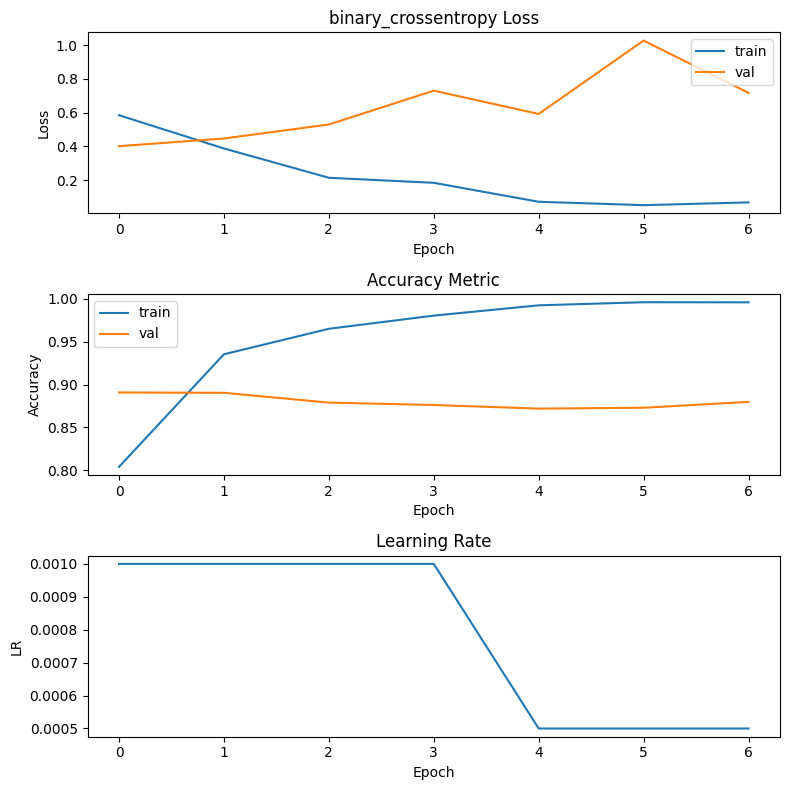

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8), tight_layout=True)

# Plot Loss
axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].set_title('binary_crossentropy Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'val'], loc='upper right')

# Plot Accuracy
axs[1].plot(hist.history['accuracy'])  # Change to 'accuracy' instead of 'binary_accuracy'
axs[1].plot(hist.history['val_accuracy'])  # Change to 'val_accuracy' instead of 'val_binary_accuracy'
axs[1].set_title('Accuracy Metric')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'val'], loc='upper left')

# Plot Learning Rate
axs[2].plot(hist.history['lr'])
axs[2].set_title('Learning Rate')
axs[2].set_ylabel('LR')
axs[2].set_xlabel('Epoch')

plt.savefig(f'/content/{name}_graphs.png')
plt.show()

In [19]:
test["cleaned_review"] = test["review"].apply(clean)
test

<ipython-input-10-9780c70dd433>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_html = BeautifulSoup(review).get_text()


,id,review,cleaned_review
0,12311_10,Naturally in a film who's main themes are of m...,naturally film main themes mortality nostalgia...
1,8348_2,This movie is a disaster within a disaster fil...,movie disaster within disaster film full great...
2,5828_4,"All in all, this is a movie for kids. We saw i...",movie kids saw tonight child loved one point k...
3,7186_2,Afraid of the Dark left me with the impression...,afraid dark left impression several different ...
4,12128_7,A very accurate depiction of small time mob li...,accurate depiction small time mob life filmed ...
...,...,...,...
24995,2155_10,"Sony Pictures Classics, I'm looking at you! So...",sony pictures classics looking sony got rights...
24996,59_10,I always felt that Ms. Merkerson had never got...,always felt ms merkerson never gotten role fit...
24997,2531_1,I was so disappointed in this movie. I am very...,disappointed movie familiar case read mark fuh...
24998,7772_8,"From the opening sequence, filled with black a...",opening sequence filled black white shots remi...


In [ ]:
sequences = tokenizer.texts_to_sequences(test.cleaned_review)
test_sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))
print(test_sequences.shape)

In [ ]:
predictions = model.predict(test_sequences).flatten()

In [25]:
predictions.shape

(25000,)

In [ ]:
output = pd.DataFrame(data={"id": test.id, "sentiment": predictions})
output.to_csv("output.csv", index=False, quoting=3)


In [26]:
output

,id,sentiment
0,12311_10,0.980705
1,8348_2,0.000068
2,5828_4,0.353684
3,7186_2,0.553398
4,12128_7,0.798257
...,...,...
24995,2155_10,0.845248
24996,59_10,0.972096
24997,2531_1,0.165128
24998,7772_8,0.970709
